In [36]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import HiveContext, Row
from pyspark.sql.types import IntegerType
import json
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

inputFile = 'mydata/health_data.csv'


conf = SparkConf().setAppName("SparkSQLAirTransit")
SparkConf().set("spark.sql.legacy.timeParserPolicy","LEGACY")

sc = SparkContext.getOrCreate(conf=conf)
hiveCtx = HiveContext(sc)
print("Loading data from " + inputFile)

Loading data from mydata/health_data.csv


/Users/abel/Envs/samaritan0/lib/python3.9/site-packages/pyspark/sql/context.py:718: FutureWarning: HiveContext is deprecated in Spark 2.0.0. Please use SparkSession.builder.enableHiveSupport().getOrCreate() instead.
  warnings.warn(
/Users/abel/Envs/samaritan0/lib/python3.9/site-packages/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


# Demo reading a CSV file stored in Hadoop using PySpark:
'''
Create a Spark session
spark = SparkSession.builder.appName("ReadFromHadoopCSV").getOrCreate()

Read the CSV file from Hadoop
df = spark.read.csv("hdfs://<Hadoop_cluster_Name>:<port>/<file_path>", header=True, inferSchema=True)

'''


## WQD7009 : BIG DATA APPLICATIONS AND ANALYTICS

In [37]:
df = hiveCtx.read.option("header",True).csv(inputFile,inferSchema =True)
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- bmi: integer (nullable = true)
 |-- drink: integer (nullable = true)
 |-- coronary_myocarditis: integer (nullable = true)
 |-- diabetes: integer (nullable = true)



In [38]:
print('View the data sample and perform data retrieval')
pd.DataFrame(df.take(10), columns=df.columns).transpose()

View the data sample and perform data retrieval


,0,1,2,3,4,5,6,7,8,9
age,89,87,82,76,68,81,87,75,60,90
bmi,23,29,30,20,24,11,23,22,14,29
drink,0,0,0,1,1,1,0,1,0,0
coronary_myocarditis,0,1,0,1,0,1,0,1,0,1
diabetes,1,0,1,0,1,1,1,0,1,1


Similarity Analysis


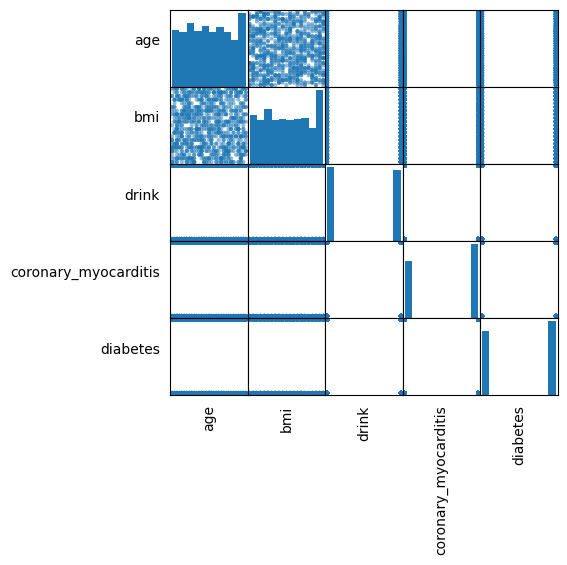

In [39]:
numeric_features = [t[0] for t in df.dtypes if t[1] == 'int']
df.select(numeric_features).describe().toPandas().transpose()

print('Similarity Analysis')
numeric_data = df.select(numeric_features).toPandas()
axs = pd.plotting.scatter_matrix(numeric_data, figsize=(5, 5));
n = len(numeric_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

In [40]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
categoricalColumns = ['age','bmi','drink','diabetes']
stages = []
# for categoricalCol in categoricalColumns:
#     stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
#     encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
#     stages += [stringIndexer, encoder]
label_stringIdx = StringIndexer(inputCol = 'coronary_myocarditis', outputCol = 'label')
stages += [label_stringIdx]
numericCols = categoricalColumns
assemblerInputs = numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]


In [41]:

from pyspark.ml import Pipeline
cols = df.columns
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df)
df = pipelineModel.transform(df)
selectedCols = ['label', 'features'] + cols
df = df.select(selectedCols)

In [42]:
print('dataset set split')
train, test = df.randomSplit([0.7, 0.3], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

dataset set split
Training Dataset Count: 712
Test Dataset Count: 288


In [43]:
from pyspark.ml.classification import LogisticRegression

from pyspark.ml.classification import RandomForestClassifier
lr = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
# lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel = lr.fit(train)
trainingSummary = lrModel.summary

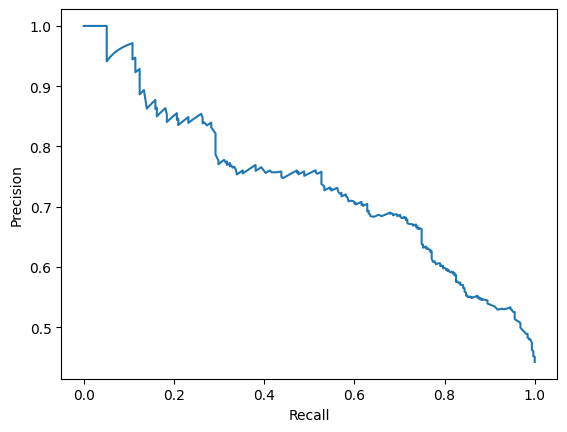

In [44]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [45]:
print('Supervised Machine Learning Machine Forest Forest Results：')
predictions = lrModel.transform(test)
predictions.select('age','bmi','drink','diabetes', 'label', 'rawPrediction', 'prediction', 'probability').show(10)
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))

Supervised Machine Learning Machine Forest Forest Results：
+---+---+-----+--------+-----+--------------------+----------+--------------------+
|age|bmi|drink|diabetes|label|       rawPrediction|prediction|         probability|
+---+---+-----+--------+-----+--------------------+----------+--------------------+
| 60| 10|    1|       1|  0.0|[8.12193266340904...|       1.0|[0.40609663317045...|
| 60| 28|    1|       0|  0.0|[11.1353706450772...|       0.0|[0.55676853225386...|
| 61| 14|    0|       1|  0.0|[3.74898264469838...|       1.0|[0.18744913223491...|
| 61| 14|    1|       1|  0.0|[6.10474050589928...|       1.0|[0.30523702529496...|
| 61| 25|    0|       1|  0.0|[6.21953722216030...|       1.0|[0.31097686110801...|
| 62| 11|    1|       0|  0.0|[8.66918038579618...|       1.0|[0.43345901928980...|
| 62| 15|    0|       1|  0.0|[7.02074257336620...|       1.0|[0.35103712866831...|
| 62| 20|    0|       1|  0.0|[7.67596387814356...|       1.0|[0.38379819390717...|
| 62| 22|    1|  

In [46]:
from pyspark.ml.classification import LogisticRegression

from pyspark.ml.classification import RandomForestClassifier
# lr = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel = lr.fit(train)

23/02/01 15:12:14 WARN InstanceBuilder$JavaBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS
23/02/01 15:12:14 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/02/01 15:12:14 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


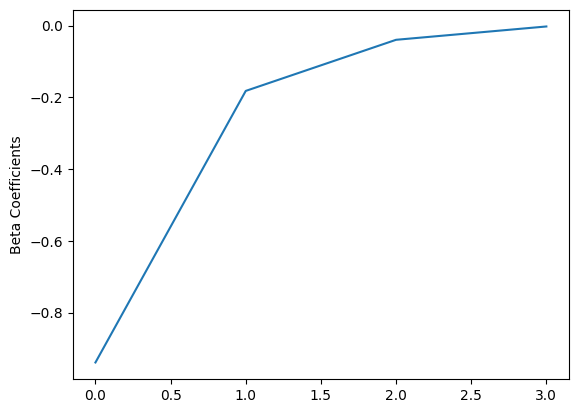

In [47]:

beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

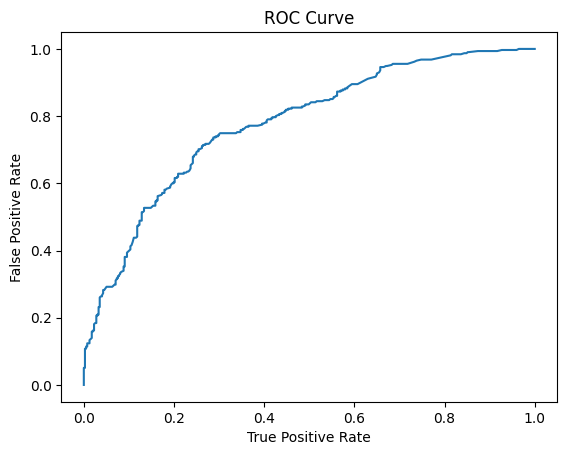

Training set areaUnderROC: 0.777321978329535


In [48]:

roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

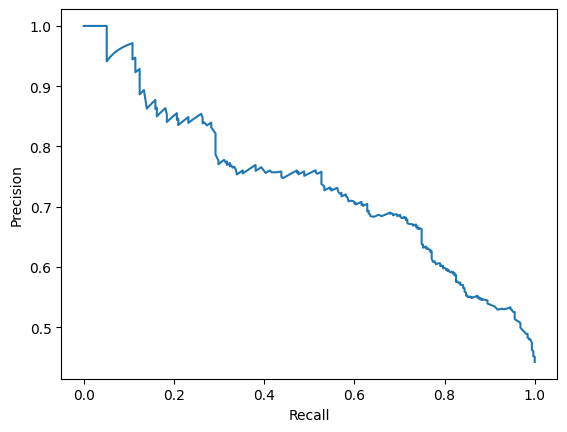

In [49]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [50]:
print('Results of supervised machine learning logistic regression：')
predictions = lrModel.transform(test)
predictions.select('age','bmi','drink','diabetes', 'label', 'rawPrediction', 'prediction', 'probability').show(10)
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))

Results of supervised machine learning logistic regression：
+---+---+-----+--------+-----+--------------------+----------+--------------------+
|age|bmi|drink|diabetes|label|       rawPrediction|prediction|         probability|
+---+---+-----+--------+-----+--------------------+----------+--------------------+
| 60| 10|    1|       1|  0.0|[0.21021447718291...|       0.0|[0.55236094144014...|
| 60| 28|    1|       0|  0.0|[0.06852594770999...|       0.0|[0.51712478622977...|
| 61| 14|    0|       1|  0.0|[-0.6807555313792...|       1.0|[0.33609269668608...|
| 61| 14|    1|       1|  0.0|[0.25855178900438...|       0.0|[0.56428025619755...|
| 61| 25|    0|       1|  0.0|[-0.6561687548631...|       1.0|[0.34160077202125...|
| 62| 11|    1|       0|  0.0|[0.10932153381626...|       0.0|[0.52730319671023...|
| 62| 15|    0|       1|  0.0|[-0.6391237040622...|       1.0|[0.34544465414144...|
| 62| 20|    0|       1|  0.0|[-0.6279478965548...|       1.0|[0.34797599152145...|
| 62| 22|    1| 

In [51]:
print('Unsupervised machine learning kmean')
from pyspark.ml.clustering import KMeans

print('2 cluster experience:')
kmeans = KMeans(k=2, seed=1)  # 2 clusters here
model = kmeans.fit(df.select('features'))

Unsupervised machine learning kmean
2 cluster experience:


In [52]:
transformed = model.transform(df)
transformed.show()    

+-----+-------------------+---+---+-----+--------------------+--------+----------+
|label|           features|age|bmi|drink|coronary_myocarditis|diabetes|prediction|
+-----+-------------------+---+---+-----+--------------------+--------+----------+
|  1.0|[89.0,23.0,0.0,1.0]| 89| 23|    0|                   0|       1|         1|
|  0.0|[87.0,29.0,0.0,0.0]| 87| 29|    0|                   1|       0|         1|
|  1.0|[82.0,30.0,0.0,1.0]| 82| 30|    0|                   0|       1|         1|
|  0.0|[76.0,20.0,1.0,0.0]| 76| 20|    1|                   1|       0|         1|
|  1.0|[68.0,24.0,1.0,1.0]| 68| 24|    1|                   0|       1|         0|
|  0.0|[81.0,11.0,1.0,1.0]| 81| 11|    1|                   1|       1|         1|
|  1.0|[87.0,23.0,0.0,1.0]| 87| 23|    0|                   0|       1|         1|
|  0.0|[75.0,22.0,1.0,0.0]| 75| 22|    1|                   1|       0|         0|
|  1.0|[60.0,14.0,0.0,1.0]| 60| 14|    0|                   0|       1|         0|
|  0

In [53]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

silhouette_scores=[]
evaluator = ClusteringEvaluator(featuresCol='features', \
metricName='silhouette', distanceMeasure='squaredEuclidean')

for K in range(2,11):
    print('k=', K)
    KMeans_=KMeans(featuresCol='features', k=K)

    KMeans_fit=KMeans_.fit(df.select('features'))

    KMeans_transform=KMeans_fit.transform(df.select('features')) 

    evaluation_score=evaluator.evaluate(KMeans_transform)

    silhouette_scores.append(evaluation_score)

k= 2
k= 3
k= 4
k= 5
k= 6
k= 7
k= 8
k= 9
k= 10


Plot Silhouette Scores vs Number of Clusters


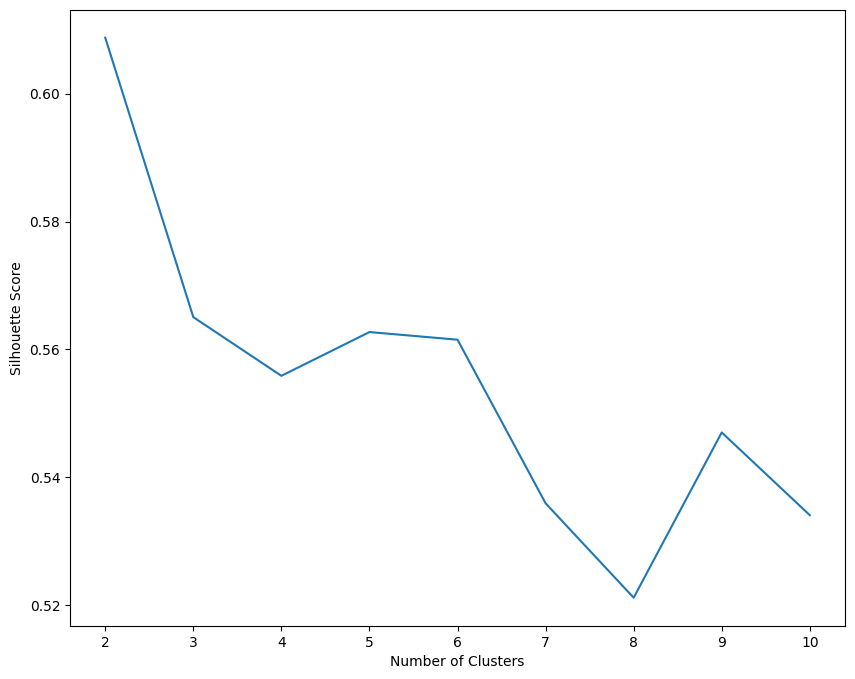

In [54]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize =(10,8))
ax.plot(range(2,11),silhouette_scores)
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Silhouette Score')
print('Plot Silhouette Scores vs Number of Clusters')